# **MODELOS**

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, log_loss
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# **PREDICCIÓN: Logistic Regression multinomial**

In [ ]:
file_path = '/content/drive/MyDrive/TFM/data/processed/df_final.parquet'

df = pd.read_parquet(file_path)

Sin SMOTE:

In [ ]:
# =========================
# 0) Normalizar fechas y cargar df_old con nombres
# =========================
df_old = pd.read_parquet("/content/drive/MyDrive/TFM/data/processed/df_new_features.parquet")

df["Date"] = pd.to_datetime(df["Date"]).dt.date
df_old["Date"] = pd.to_datetime(df_old["Date"]).dt.date

# =========================
# 1) Definir el rango de predicción
# =========================
start_date = pd.to_datetime("2025-09-12").date()
end_date   = pd.to_datetime("2025-09-15").date()

mask_pred = (
    (df["Season"] == 2025) &
    (df["Date"] >= start_date) &
    (df["Date"] <= end_date)
)

pred_idx = df.loc[mask_pred].assign(_idx=lambda x: x.index) \
                           .sort_values(["Date","_idx"])["_idx"].tolist()

if len(pred_idx) != 10:
    print(f"⚠️ Aviso: se han seleccionado {len(pred_idx)} partidos en el rango {start_date}–{end_date}.")

# =========================
# 2) Construir X, y (quitando columnas no predictoras)
# =========================
drop_cols = ['FTR', 'target', 'Date','has_xg_data', 'overround', 'pimp2', 'B365D', 'a_squad_size_prev_season', 'away_form_gd_6', 'home_form_gd_6']
drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols)
y = df["target"]

mask_train = (~mask_pred) & (y.notna())

X_train = X.loc[mask_train].copy()
y_train = y.loc[mask_train].astype(int)

X_pred  = X.loc[pred_idx].copy()

for D in (X_train, X_pred):
    if "Season" in D.columns:
        D.drop(columns=["Season"], inplace=True)

X_pred = X_pred.reindex(columns=X_train.columns, fill_value=np.nan)

# =========================
# 3) Modelo (sin SMOTE; sin multi_class para evitar warning)
# =========================
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42))
])
pipe.fit(X_train, y_train)

# =========================
# 4) Predicción
# =========================
proba_pred = pipe.predict_proba(X_pred)
pred_labels = pipe.predict(X_pred)

class_map = {0: "A", 1: "D", 2: "H"}
pred_1x2 = pd.Series(pred_labels).map(class_map).values

classes = list(pipe.named_steps["logreg"].classes_)
proba_df = pd.DataFrame(proba_pred, columns=[class_map[c] for c in classes])
for lab in ["H","D","A"]:
    if lab not in proba_df.columns:
        proba_df[lab] = np.nan
proba_df = proba_df[["H","D","A"]]

# =========================
# 5) Recuperar NOMBRES desde df_old
# =========================
needed_cols = ["Date","HomeTeam_norm","AwayTeam_norm","Season"]
missing = [c for c in needed_cols if c not in df_old.columns]
if missing:
    raise KeyError(f"df_old debe contener: {missing}")

old_slice = df_old[
    (df_old["Season"] == 2025) &
    (df_old["Date"] >= start_date) &
    (df_old["Date"] <= end_date)
][["Date","HomeTeam_norm","AwayTeam_norm"]].copy()

old_slice = old_slice.sort_values("Date").reset_index(drop=True)

dates_pred_ord = df.loc[pred_idx, "Date"].sort_values().reset_index(drop=True)
order = np.argsort(df.loc[pred_idx, "Date"].values)
proba_df_ord = proba_df.iloc[order].reset_index(drop=True)
pred_1x2_ord = pd.Series(pred_1x2).iloc[order].reset_index(drop=True)

if len(old_slice) != len(dates_pred_ord):
    print(f"⚠️ df_old tiene {len(old_slice)} partidos en el rango; df tiene {len(dates_pred_ord)}.")

# =========================
# 6) Resultado final
# =========================
out = pd.concat([
    dates_pred_ord.rename("Date"),
    old_slice[["HomeTeam_norm","AwayTeam_norm"]],
    pred_1x2_ord.rename("Pred"),
    proba_df_ord.rename(columns={"H":"Prob_H","D":"Prob_D","A":"Prob_A"})
], axis=1).sort_values("Date").reset_index(drop=True)

print(out)

         Date HomeTeam_norm AwayTeam_norm Pred    Prob_H    Prob_D    Prob_A
0  2025-09-12       sevilla         elche    H  0.515326  0.267591  0.217083
1  2025-09-13        getafe        oviedo    H  0.444867  0.313421  0.241711
2  2025-09-13      sociedad   real madrid    A  0.161232  0.285091  0.553677
3  2025-09-13    ath bilbao        alaves    H  0.551637  0.303190  0.145172
4  2025-09-13    ath madrid    villarreal    H  0.489984  0.332929  0.177087
5  2025-09-14         celta        girona    H  0.589197  0.268258  0.142545
6  2025-09-14       levante         betis    A  0.293726  0.342873  0.363401
7  2025-09-14       osasuna     vallecano    H  0.377091  0.347188  0.275721
8  2025-09-14     barcelona      valencia    H  0.844442  0.115701  0.039857
9  2025-09-15       espanol      mallorca    D  0.350276  0.373549  0.276176


Con SMOTE:

In [ ]:
# =========================
# 0) Normalizar fechas y cargar df_old con nombres
# =========================
df_old = pd.read_parquet("/content/drive/MyDrive/TFM/data/processed/df_new_features.parquet")  # <-- AJUSTA

df["Date"] = pd.to_datetime(df["Date"]).dt.date
df_old["Date"] = pd.to_datetime(df_old["Date"]).dt.date

# =========================
# 1) Definir rango de predicción
# =========================
start_date = pd.to_datetime("2025-09-12").date()
end_date   = pd.to_datetime("2025-09-15").date()

mask_pred = (
    (df["Season"] == 2025) &
    (df["Date"] >= start_date) &
    (df["Date"] <= end_date)
)
pred_idx = df.loc[mask_pred].index.tolist()

if len(pred_idx) != 10:
    print(f"⚠️ Aviso: se han seleccionado {len(pred_idx)} partidos en el rango {start_date}–{end_date}.")

# =========================
# 2) Construir X, y (quitando columnas no predictoras)
# =========================
drop_cols = ['FTR', 'target', 'Date','has_xg_data', 'overround', 'pimp2', 'B365D', 'a_squad_size_prev_season', 'away_form_gd_6', 'home_form_gd_6']
drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols)
y = df["target"]

mask_train = (~mask_pred) & (y.notna())

X_train = X.loc[mask_train].copy()
y_train = y.loc[mask_train].astype(int)
X_pred  = X.loc[pred_idx].copy()

for D in (X_train, X_pred):
    if "Season" in D.columns:
        D.drop(columns=["Season"], inplace=True)

X_pred = X_pred.reindex(columns=X_train.columns, fill_value=np.nan)

# =========================
# 3) Modelo con SMOTE
# =========================
pipe = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("logreg", LogisticRegression(solver="saga", penalty="l2", max_iter=1000, random_state=42))
])
pipe.fit(X_train, y_train)

# =========================
# 4) Predicción SOLO para esos 10 índices
# =========================
proba_pred = pipe.predict_proba(X_pred)
pred_labels = pipe.predict(X_pred)

class_map = {0:"A", 1:"D", 2:"H"}
pred_1x2 = pd.Series(pred_labels).map(class_map).values

classes = list(pipe.named_steps["logreg"].classes_)
proba_df = pd.DataFrame(proba_pred, columns=[class_map[c] for c in classes])
for lab in ["H","D","A"]:
    if lab not in proba_df.columns:
        proba_df[lab] = np.nan
proba_df = proba_df[["H","D","A"]]

# =========================
# 5) Recuperar NOMBRES desde df_old
# =========================
old_slice = df_old[
    (df_old["Season"] == 2025) &
    (df_old["Date"] >= start_date) &
    (df_old["Date"] <= end_date)
][["Date","HomeTeam_norm","AwayTeam_norm"]].sort_values("Date").reset_index(drop=True)

dates_pred_ord = df.loc[pred_idx, "Date"].sort_values().reset_index(drop=True)
order = np.argsort(df.loc[pred_idx, "Date"].values)

proba_df_ord = proba_df.iloc[order].reset_index(drop=True)
pred_1x2_ord = pd.Series(pred_1x2).iloc[order].reset_index(drop=True)

# =========================
# 6) Resultado final
# =========================
out = pd.concat([
    dates_pred_ord.rename("Date"),
    old_slice[["HomeTeam_norm","AwayTeam_norm"]],
    pred_1x2_ord.rename("Pred"),
    proba_df_ord.rename(columns={"H":"Prob_H","D":"Prob_D","A":"Prob_A"})
], axis=1).sort_values("Date").reset_index(drop=True)

print(out)

         Date HomeTeam_norm AwayTeam_norm Pred    Prob_H    Prob_D    Prob_A
0  2025-09-12       sevilla         elche    D  0.353295  0.384728  0.261976
1  2025-09-13        getafe        oviedo    D  0.319958  0.390983  0.289059
2  2025-09-13      sociedad   real madrid    A  0.088885  0.371646  0.539469
3  2025-09-13    ath bilbao        alaves    D  0.379048  0.444084  0.176868
4  2025-09-13    ath madrid    villarreal    D  0.337684  0.459493  0.202823
5  2025-09-14         celta        girona    D  0.417532  0.427832  0.154636
6  2025-09-14       levante         betis    D  0.181438  0.442115  0.376447
7  2025-09-14       osasuna     vallecano    D  0.225592  0.456761  0.317648
8  2025-09-14     barcelona      valencia    H  0.768631  0.173464  0.057906
9  2025-09-15       espanol      mallorca    D  0.222178  0.480022  0.297800


# **EVALUACIÓN HISTÓRICA: Logistic Regression multinomial**

In [ ]:
file_path = '/content/drive/MyDrive/TFM/data/processed/df_final.parquet'

df = pd.read_parquet(file_path)

Sin SMOTE:

In [ ]:
def run_logreg_eval_no_smote(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    random_state: int = 42,
):
    """
    Entrena y evalúa una regresión logística SIN SMOTE.

    - Train: Season <= train_until_season
    - Test : Season >  train_until_season  (y si test_until_season no es None, Season <= test_until_season)
    - Excluye partidos futuros (target NaN).
    - Si with_odds=True, exige cuotas no NaN en train/test.
    - Descarta filas con NaN en algún feature de X (rápido y seguro).
    """

    # --- columnas a excluir según modo ---
    drop_cols_common = [
        'FTR', 'target', 'Date', 'has_xg_data',
        'a_squad_size_prev_season', 'away_form_gd_6', 'home_form_gd_6'
    ]
    if with_odds:
        drop_cols_mode = ['overround', 'pimp2', 'B365D']
    else:
        drop_cols_mode = ['fase_temporada_inicio','fase_temporada_mitad',
                          'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2']
    drop_cols = list(dict.fromkeys(drop_cols_common + drop_cols_mode))

    # --- X e y; filtrado de válidos ---
    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta la columna 'Season' en X para hacer el split temporal.")

    # --- split temporal ---
    train_mask = X_all['Season'] <= train_until_season
    test_mask  = X_all['Season'] >  train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_train = X_all.loc[train_mask].drop(columns=['Season'])
    y_train = y_all.loc[train_mask]

    X_test  = X_all.loc[test_mask].drop(columns=['Season'])
    y_test  = y_all.loc[test_mask]

    if len(X_train)==0 or len(np.unique(y_train))<2:
        raise ValueError("TRAIN vacío o con <2 clases. Revisa filtros/temporadas.")

    # --- escalado ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test) if len(X_test) else None

    # --- modelo ---
    model = LogisticRegression(
        solver='saga', penalty='l2', max_iter=1000,
        random_state=random_state
    )
    model.fit(X_train_scaled, y_train)

    classes_used = model.classes_

    # --- métricas train ---
    ytr_pred  = model.predict(X_train_scaled)
    ytr_proba = model.predict_proba(X_train_scaled)
    ytr_bin   = label_binarize(y_train, classes=classes_used)
    brier_tr  = np.mean(np.sum((ytr_proba - ytr_bin)**2, axis=1))
    acc_tr    = accuracy_score(y_train, ytr_pred)
    ll_tr     = log_loss(y_train, ytr_proba, labels=classes_used)

    metrics_train = {"accuracy": acc_tr, "log_loss": ll_tr, "brier": brier_tr, "n_train": len(y_train)}

    # --- métricas test ---
    if len(X_test):
        yte_pred  = model.predict(X_test_scaled)
        yte_proba = model.predict_proba(X_test_scaled)
        yte_bin   = label_binarize(y_test, classes=classes_used)
        brier_te  = np.mean(np.sum((yte_proba - yte_bin)**2, axis=1))
        acc_te    = accuracy_score(y_test, yte_pred)
        ll_te     = log_loss(y_test, yte_proba, labels=classes_used)
        metrics_test = {
            "accuracy": acc_te, "log_loss": ll_te, "brier": brier_te,
            "n_test": len(y_test),
            "season_min": int(X_all.loc[test_mask, 'Season'].min()),
            "season_max": int(X_all.loc[test_mask, 'Season'].max())
        }
    else:
        print("⚠️ TEST vacío tras filtrar (no hay partidos jugados en el rango de test).")
        metrics_test = None

    # --- reporte ---
    test_range_txt = (f"{train_until_season+1}..{test_until_season}"
                      if test_until_season is not None else f">{train_until_season}")
    print("Logistic Regression (sin SMOTE)", "(con cuotas)" if with_odds else "(sin cuotas)")
    print("\n=== Train ==="); print(metrics_train)
    print(f"\n=== Test (Seasons {test_range_txt}) ===")
    print(metrics_test if metrics_test else "Sin test disponible.")

    return model, scaler, (metrics_train, metrics_test)

In [ ]:
# CON CUOTAS
model, scaler, (mtr_tr, mtr_te) = run_logreg_eval_no_smote(df, train_until_season=2024, test_until_season=2025, with_odds=True)

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5520775623268698, 'log_loss': 0.9483095939904089, 'brier': np.float64(0.5626058130253195), 'n_train': 7220}

=== Test (Seasons 2025..2025) ===
{'accuracy': 0.47619047619047616, 'log_loss': 0.9445730298688543, 'brier': np.float64(0.5609560557137647), 'n_test': 21, 'season_min': 2025, 'season_max': 2025}


In [ ]:
# SIN CUOTAS
# model, scaler, (mtr_tr, mtr_te) = run_logreg_eval_no_smote(df, train_until_season=2023, with_odds=False)

Con SMOTE:

In [ ]:
def run_logreg_eval(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    random_state: int = 42,
):
    """
    Entrena una regresión logística (SMOTE + escalado) y evalúa en TEST.
      - Train: Season <= train_until_season
      - Test : Season > train_until_season (y si test_until_season no es None, Season <= test_until_season)
      - Excluye partidos futuros (target NaN).
      - Si with_odds=True, exige cuotas no NaN en train/test.
      - Descarta filas con NaN en cualquier feature de X.
    """

    # --- columnas a excluir según modo ---
    drop_cols_common = [
        'FTR', 'target', 'Date', 'has_xg_data',
        'a_squad_size_prev_season', 'away_form_gd_6', 'home_form_gd_6'
    ]
    if with_odds:
        drop_cols_mode = ['overround', 'pimp2', 'B365D']
    else:
        drop_cols_mode = ['fase_temporada_inicio','fase_temporada_mitad',
                          'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2']
    drop_cols = list(dict.fromkeys(drop_cols_common + drop_cols_mode))

    # --- X e y; filtrado de válidos ---
    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid_mask = y_all.notna()
    if with_odds:
        for c in ['B365H', 'B365A']:
            if c in X_all.columns:
                valid_mask &= X_all[c].notna()
    valid_mask &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid_mask].copy()
    y_all = y_all.loc[valid_mask].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta la columna 'Season' para hacer el split temporal.")

    # --- split temporal ---
    train_mask = X_all['Season'] <= train_until_season
    test_mask  = X_all['Season'] >  train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_train = X_all.loc[train_mask].drop(columns=['Season'])
    y_train = y_all.loc[train_mask]

    X_test  = X_all.loc[test_mask].drop(columns=['Season'])
    y_test  = y_all.loc[test_mask]

    if len(X_train) == 0 or len(y_train.unique()) < 2:
        raise ValueError("TRAIN vacío o con menos de 2 clases. Revisa filtros/temporadas.")

    # --- escalado ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test) if len(X_test) else None

    # --- SMOTE ---
    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

    # --- modelo ---
    model = LogisticRegression(
        solver='saga', penalty='l2', max_iter=1000, random_state=random_state
    )
    model.fit(X_train_res, y_train_res)

    classes_used = model.classes_

    # --- métricas train ---
    ytr_pred  = model.predict(X_train_scaled)
    ytr_proba = model.predict_proba(X_train_scaled)
    ytr_bin   = label_binarize(y_train, classes=classes_used)
    brier_tr  = float(np.mean(np.sum((ytr_proba - ytr_bin) ** 2, axis=1)))
    acc_tr    = float(accuracy_score(y_train, ytr_pred))
    ll_tr     = float(log_loss(y_train, ytr_proba, labels=classes_used))

    metrics_train = {
        "accuracy": acc_tr,
        "log_loss": ll_tr,
        "brier":    brier_tr,
        "n_train":  int(len(y_train))
    }

    # --- métricas test ---
    if len(X_test):
        yte_pred  = model.predict(X_test_scaled)
        yte_proba = model.predict_proba(X_test_scaled)
        yte_bin   = label_binarize(y_test, classes=classes_used)
        brier_te  = float(np.mean(np.sum((yte_proba - yte_bin) ** 2, axis=1)))
        acc_te    = float(accuracy_score(y_test, yte_pred))
        ll_te     = float(log_loss(y_test, yte_proba, labels=classes_used))
        metrics_test = {
            "accuracy": acc_te,
            "log_loss": ll_te,
            "brier":    brier_te,
            "n_test":   int(len(y_test)),
            "season_min": int(X_all.loc[test_mask, 'Season'].min()),
            "season_max": int(X_all.loc[test_mask, 'Season'].max())
        }
    else:
        print("⚠️ TEST vacío tras filtrar (no hay partidos jugados en el rango de test).")
        metrics_test = None

    # --- reporte ---
    test_range_txt = (f"{train_until_season+1}..{test_until_season}"
                      if test_until_season is not None else f">{train_until_season}")
    print("Logistic Regression con SMOTE", "(con cuotas)" if with_odds else "(sin cuotas)")
    print("\n=== Train ==="); print(metrics_train)
    print(f"\n=== Test (Seasons {test_range_txt}) ===")
    print(metrics_test if metrics_test else "Sin test disponible.")

    return model, scaler, (metrics_train, metrics_test)

In [ ]:
# MODO CON CUOTAS
model, scaler, (mtr_tr, mtr_te) = run_logreg_eval(df, train_until_season=2023, test_until_season=2024, with_odds=True)

Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5074561403508772, 'log_loss': 0.9842577630646778, 'brier': 0.5860409474763492, 'n_train': 6840}

=== Test (Seasons 2024..2024) ===
{'accuracy': 0.5157894736842106, 'log_loss': 0.994216975861483, 'brier': 0.5910384599629862, 'n_test': 380, 'season_min': 2024, 'season_max': 2024}


In [ ]:
# MODO SIN CUOTAS
# model, scaler, (mtr_train, mtr_test) = run_logreg_eval(df, train_until_season=2023, with_odds=False)

Con este modelo obtengo el mejor **Accuracy** (porcentaje de aciertos totales), pero esta métrica ignora como de seguras son esas esas predicciones.

$$
\text{Accuracy} = \frac{\text{Número de aciertos}}{\text{Número total de predicciones}}
$$

Para ello se utiliza el **Log Loss** (Cross-Entropy Loss), métrica que mide qué tan buenas son las probabilidades que predice mi modelo de clasificación. A esta métrica no solo le importa acertar la clase, sino cuán seguro está el modelo.

$$
\text{LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} y_{ij} \cdot \log(p_{ij})
$$

donde:

- $y_{ij}$ = 1 si la clase real del ejemplo $i$ es la clase $j$, y 0 en caso contrario.
- $p_{ij}$ es la probabilidad predicha por el modelo de que el ejemplo $i$ pertenezca a la clase $j$.

Tener un Log Loss alto en este caso significaría dar una probabilidad alta a la clase incorrecta, o lo que es lo mismo, dar una probabilidad baja a la clase correcta.

Por último añadí también el **Brier Score**, que es una métrica que evalúa cuán cercanas están las probabilidades predichas por tu modelo respecto a la realidad, comparando la distribución de probabilidades contra la clase real (codificada en one-hot). Es como un error cuadrático medio (MSE) para probabilidades.

$$
\text{Brier Score} = \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} (p_{ij} - y_{ij})^2
$$

donde:

- $N$ es el número de ejemplos.
- $K$ es el número de clases (en este caso 3: victoria local, empate, victoria visitante).
- $p_{ij}$ es la probabilidad predicha por el modelo de que el ejemplo $i$ pertenezca a la clase $j$.
- $y_{ij}$ es 1 si la clase real del ejemplo $i$ es la clase $j$, y 0 en caso contrario.

Un Brier Score de 0 significa que las probabilidades dadas por el modelo son perfectas, mientras que uno del 0.66 en nuestro caso sería un modelo completamente aleatorio.


## Selección de variables

La función `forward_selection` implementa un algoritmo clásico de selección de variables hacia adelante (**forward feature selection**) sobre un modelo de regresión logística multiclase con escalado de variables.

Va añadiendo sucesivamente la variable que mejor mejora el rendimiento del modelo (según accuracy o log_loss), una por una.





In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss
import numpy as np

def forward_selection(X, y, max_features=20, scoring='accuracy'):
    selected_features = []
    remaining_features = list(X.columns)
    scores = []

    for i in range(min(max_features, len(remaining_features))):
        best_score = -np.inf if scoring == 'accuracy' else np.inf
        best_feature = None

        for feature in remaining_features:
            current_features = selected_features + [feature]

            model = make_pipeline(
                StandardScaler(),
                LogisticRegression(max_iter=1000, solver='lbfgs')
            )

            model.fit(X[current_features], y)
            y_pred = model.predict(X[current_features])
            y_proba = model.predict_proba(X[current_features])

            if scoring == 'accuracy':
                score = accuracy_score(y, y_pred)
                if score > best_score:
                    best_score = score
                    best_feature = feature
            elif scoring == 'log_loss':
                score = log_loss(y, y_proba)
                if score < best_score:
                    best_score = score
                    best_feature = feature
            else:
                raise ValueError("scoring debe ser 'accuracy' o 'log_loss'.")

        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            scores.append(best_score)

        print(f"[{i+1}] Añadida: {best_feature} | Score: {best_score:.4f}")

    return selected_features, scores

In [ ]:
selected, scores = forward_selection(X_train, y_train, max_features=81, scoring='accuracy')

[1] Añadida: pimp1 | Score: 0.5430
[2] Añadida: home_prev_position | Score: 0.5447
[3] Añadida: h_avg_age_prev_season | Score: 0.5463
[4] Añadida: home_total_points_cum | Score: 0.5471
[5] Añadida: away_post_big_odds_win | Score: 0.5480
[6] Añadida: home_points_cum | Score: 0.5490
[7] Añadida: home_avg_yellows_last10 | Score: 0.5493
[8] Añadida: home_position_zone | Score: 0.5494
[9] Añadida: h_elo | Score: 0.5496
[10] Añadida: home_effectiveness | Score: 0.5496
[11] Añadida: B365A | Score: 0.5504
[12] Añadida: away_final_position_prev_season | Score: 0.5507
[13] Añadida: a_value_avg_mio_prev_season | Score: 0.5509
[14] Añadida: away_avg_fouls_last10 | Score: 0.5509
[15] Añadida: a_avg_age_prev_season | Score: 0.5512
[16] Añadida: home_post_big_odds_win | Score: 0.5513
[17] Añadida: home_dynamic_pos_change_prev_season | Score: 0.5510
[18] Añadida: home_avg_shotsontarget_last10 | Score: 0.5510
[19] Añadida: away_avg_shotsontarget_last10 | Score: 0.5512
[20] Añadida: a_value_mio_prev_sea

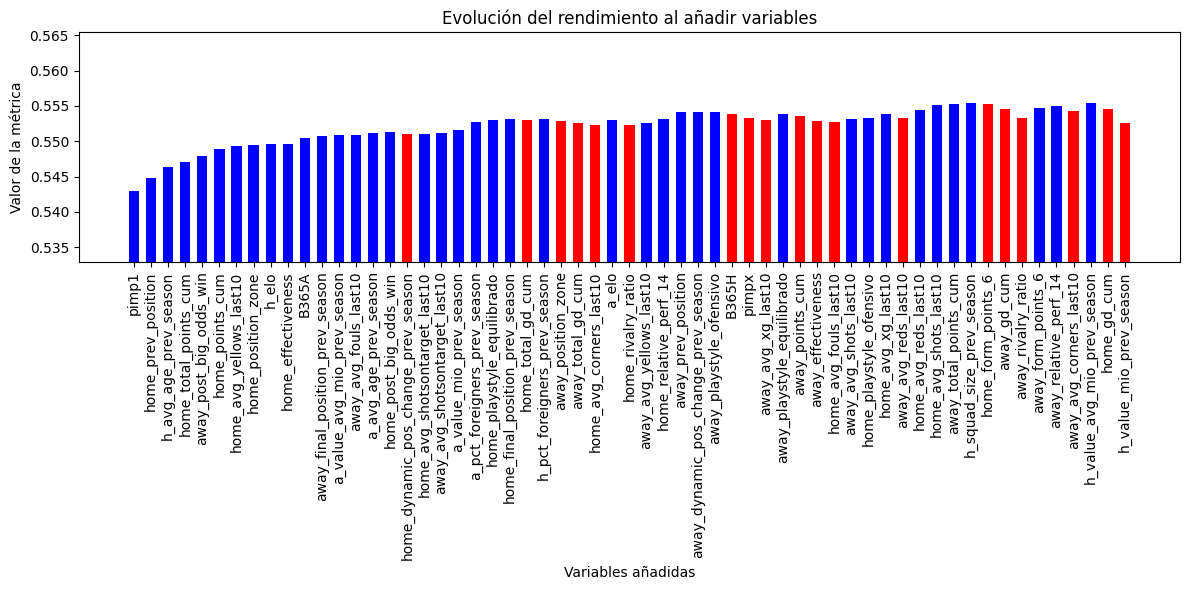

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Suponemos que tienes las listas: selected (variables) y scores (métricas acumuladas)

# Calcular diferencia respecto al valor anterior
deltas = np.diff([0] + scores)
colors = ['blue' if delta >= 0 else 'red' for delta in deltas]

plt.figure(figsize=(12,6))
bar_width = 0.6  # Reducir ancho de barra para separarlas
indices = np.arange(len(selected))

plt.bar(indices, scores, color=colors, width=bar_width)
plt.xticks(indices, selected, rotation=90)
plt.xlabel('Variables añadidas')
plt.ylabel('Valor de la métrica')
plt.title('Evolución del rendimiento al añadir variables')

plt.ylim(min(scores) - 0.01, max(scores) + 0.01)
plt.tight_layout()
plt.show()


Se implementó un proceso de selección hacia adelante (forward selection) sobre el modelo de regresión logística con variables estandarizadas. Este procedimiento consiste en partir sin predictores y añadir, en cada iteración, la variable que mayor mejora produce en el rendimiento del modelo. Se evaluaron dos métricas complementarias como criterio de selección: el accuracy (para priorizar aciertos de clasificación) y el log loss (para priorizar la calibración de las probabilidades). Esta técnica permitió reducir la dimensionalidad del conjunto original y determinar el orden de relevancia de las variables desde el punto de vista predictivo.

# **Resultados**

**MATRIZ DE CONFUSIÓN**

In [ ]:
# ---------- Split de TEST con tope de temporada ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    # válidas: sin NaN en y ni en X; si with_odds, exige cuotas clave
    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask  = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

# ---------- Alinear columnas de X a las usadas en el fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    """
    Alinea X para que tenga EXACTAMENTE las columnas usadas en el fit.
    - Usa feature_names si se proporcionan; si no, intenta fitter.feature_names_in_.
    - Elimina columnas extra.
    - Lanza error si faltan columnas del fit.
    """
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        # Si el scaler/model se entrenó con arrays numpy, no hay nombres guardados.
        # En ese caso asumimos que X ya coincide.
        return X

    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Asegúrate de usar el MISMO esquema (with_odds / drop_cols) que en el fit, "
            "o pasa explícitamente 'feature_names' del entrenamiento."
        )
    return X[cols_fit]

# ---------- Matriz de confusión con rango de test configurable ----------
def plot_confusion_for_logreg(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    feature_names: list[str] | None = None   # opcional: forzar lista de features del fit
):
    import matplotlib.pyplot as plt  # import local para evitar NameError

    # 1) reconstruir TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # 2) alinear columnas a las del fit (usamos scaler; también valdría el modelo)
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # 3) predecir
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    # 4) plot
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    classes_used = model.classes_
    display_labels = [class2label.get(c, str(c)) for c in classes_used]

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        labels=classes_used,
        display_labels=display_labels,
        cmap='Blues', colorbar=False
    )
    rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    plt.title(f'Confusion Matrix (Seasons {rango})')
    plt.tight_layout()
    plt.show()

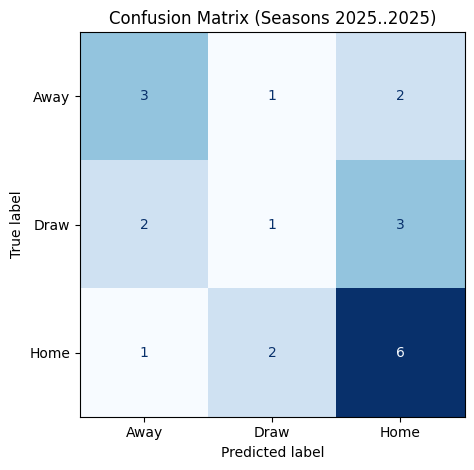

In [ ]:
plot_confusion_for_logreg(df, model, scaler, train_until_season=2024, test_until_season=2025, with_odds=True)

In [ ]:
# -------- split TEST con tope de temporada --------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para hacer el split temporal.")

    test_mask  = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

# -------- alinear columnas a las usadas en el fit --------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        # si se entrenó con arrays, no hay nombres; asumimos que X ya coincide
        return X
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Asegúrate de usar el MISMO esquema (with_odds / drop_cols) que en el fit, "
            "o pasa explícitamente 'feature_names' del entrenamiento."
        )
    return X[cols_fit]

# -------- classification_report con rango de test configurable --------
def print_classification_report_for_logreg(
    df: pd.DataFrame, model, scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    digits: int = 3,
    feature_names: list[str] | None = None   # opcional: columnas del fit
):
    """
    Reconstruye TEST (Season in (train_until_season, test_until_season]) si se indica,
    alinea columnas al fit y muestra classification_report. Robusto a clases ausentes.
    """
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # Alinear a columnas de entrenamiento
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # Predecir
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    # Etiquetas
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    classes_used = model.classes_
    target_names = [class2label.get(c, str(c)) for c in classes_used]

    # Reporte
    print(
        classification_report(
            y_test, y_pred,
            labels=classes_used,
            target_names=target_names,
            zero_division=0,
            digits=digits
        )
    )

In [ ]:
print_classification_report_for_logreg(df, model, scaler, train_until_season=2024, test_until_season=2025, with_odds=True)

              precision    recall  f1-score   support

        Away      0.500     0.500     0.500         6
        Draw      0.250     0.167     0.200         6
        Home      0.545     0.667     0.600         9

    accuracy                          0.476        21
   macro avg      0.432     0.444     0.433        21
weighted avg      0.448     0.476     0.457        21



**AUC Y CURVA ROC**

In [ ]:
# ---------- Split de TEST con tope de temporada ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

# ---------- Alinear columnas de X a las usadas en el fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X  # entrenaste con arrays; asumimos que X ya coincide
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Usa el mismo esquema (with_odds/drop_cols) que en el fit, "
            "o pasa 'feature_names' con la lista exacta de columnas del entrenamiento."
        )
    return X[cols_fit]

# ---------- Curvas ROC multiclase con rango de test configurable ----------
def plot_multiclass_roc(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    feature_names: list[str] | None = None
):
    import matplotlib.pyplot as plt  # lazy import para evitar NameError

    # 1) TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # 2) Alinear columnas a las del fit
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # 3) Probabilidades
    X_test_scaled = scaler.transform(X_test)
    y_proba = model.predict_proba(X_test_scaled)

    # 4) Binarización y etiquetas
    classes_used = model.classes_
    y_bin = label_binarize(y_test, classes=classes_used)
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    labels_text = [class2label.get(c, str(c)) for c in classes_used]

    # 5) Curvas por clase (si hay positivos y negativos)
    plt.figure()
    auc_per_class, weights = [], []
    n = len(y_test)

    for k, cls in enumerate(classes_used):
        y_true_k = y_bin[:, k]
        y_score_k = y_proba[:, k]
        pos = y_true_k.sum()
        neg = n - pos
        if pos > 0 and neg > 0:
            fpr, tpr, _ = roc_curve(y_true_k, y_score_k)
            auc_k = roc_auc_score(y_true_k, y_score_k)
            auc_per_class.append(auc_k)
            weights.append(pos)
            plt.plot(fpr, tpr, label=f"{labels_text[k]} (AUC = {auc_k:.2f})")
        else:
            print(f"Nota: '{labels_text[k]}' no tiene suficientes positivos/negativos en TEST; omito su curva.")

    plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    plt.title(f"Curvas ROC por clase (Seasons {rango})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6) AUC macro y weighted (solo con clases válidas)
    if auc_per_class:
        auc_macro = float(np.mean(auc_per_class))
        auc_weighted = float(np.average(auc_per_class, weights=weights)) if sum(weights) > 0 else auc_macro
        print(f"\nAUC macro: {auc_macro:.3f}")
        print(f"AUC weighted: {auc_weighted:.3f}")
    else:
        print("\nNo se pudieron calcular AUCs (todas las clases carecen de positivos/negativos suficientes en TEST).")

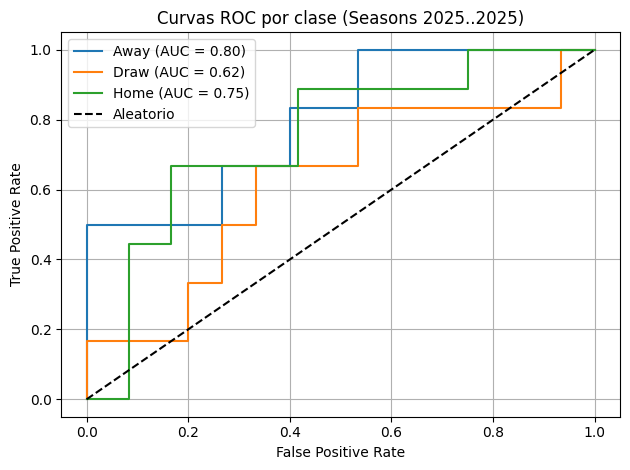


AUC macro: 0.724
AUC weighted: 0.728


In [ ]:
plot_multiclass_roc(df, model, scaler, train_until_season=2024, test_until_season=2025, with_odds=True)

Por último, pero no por ello menos importante vamos a estudiar la última métrica: El **ROI (Return on Investment)**.

$$
ROI = \frac{\text{Beneficio}}{\text{Inversión}}
$$

Con el código siguiente lo que estoy haciendo es simular una apuesta de un euro al resultado que predice mi modelo, en todos los partidos que hay en test. Si se acierta sumamos la cuota que ofrece Bet365 pero si falla se resta la unidad apostada. Con esto calculamos el beneficio neto y el ROI.

In [ ]:
# ---------- Split de TEST con tope de temporada ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

# ---------- Alinear X a las columnas del fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X  # entrenaste con arrays; asumimos que X ya coincide
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Usa el mismo esquema (with_odds/drop_cols) que en el fit, "
            "o pasa 'feature_names' con la lista exacta del entrenamiento."
        )
    return X[cols_fit]

# ---------- Simulación de ROI con tope de temporada y alineación de features ----------
def simulate_bet365_roi(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    meta_df: pd.DataFrame | None = None,
    feature_names: list[str] | None = None
):
    """
    Simula apostar SIEMPRE al resultado predicho por el modelo en TEST:
      - Train: Season <= train_until_season (ya entrenado fuera).
      - Test : Season ∈ (train_until_season, test_until_season] si se indica; si no, todas las posteriores.
      - Alinea X_test a las columnas del fit (scaler.feature_names_in_ o feature_names).
      - Toma Date/Home/Away/B365* de df y, si faltan, de meta_df (p. ej., df_old).
      - Filtra partidos sin cuotas completas (B365H/D/A).
    """
    # 1) TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rng}).")
        return None, np.nan, np.nan

    # 2) Alinear columnas a las del fit
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # 3) Predicciones
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    # 4) Meta-información para reporte/ROI
    want = ['Date','HomeTeam_norm','AwayTeam_norm','B365H','B365D','B365A']

    def _pull_cols(source: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
        have = [c for c in cols if source is not None and c in source.columns]
        if not have:
            return pd.DataFrame(index=X_test.index)
        return source.reindex(X_test.index)[have]

    meta_from_df  = _pull_cols(df, want)
    meta_from_old = _pull_cols(meta_df, want)

    meta = meta_from_df.copy()
    for c in want:
        if c not in meta.columns:
            meta[c] = np.nan
    for c in want:
        if c in meta_from_old.columns:
            meta[c] = meta[c].where(meta[c].notna(), meta_from_old[c])

    results_df = pd.DataFrame(index=X_test.index)
    for c in want:
        if c in meta.columns:
            results_df[c] = meta[c]

    results_df['true_result'] = y_test.values
    results_df['predicted_result'] = y_pred

    # 5) Exigir cuotas completas
    if not set(['B365H','B365D','B365A']).issubset(results_df.columns):
        missing = [c for c in ['B365H','B365D','B365A'] if c not in results_df.columns]
        raise ValueError(f"No encuentro cuotas en df ni en meta_df: faltan {missing}")

    mask_odds = results_df[['B365H','B365D','B365A']].notna().all(axis=1)
    results_df = results_df.loc[mask_odds].copy()
    if results_df.empty:
        print("⚠️ No hay partidos con cuotas completas en TEST (ni en df ni en meta_df).")
        return None, np.nan, np.nan

    # 6) Cuota asociada a la predicción (0=Away->B365A, 1=Draw->B365D, 2=Home->B365H)
    odds_matrix = results_df[['B365A','B365D','B365H']].to_numpy()
    idx_map = results_df['predicted_result'].map({0:0, 1:1, 2:2}).to_numpy()
    results_df['predicted_odds'] = odds_matrix[np.arange(len(results_df)), idx_map]

    # 7) Simulación de apuesta
    results_df['bet_outcome'] = np.where(
        results_df['predicted_result'] == results_df['true_result'],
        results_df['predicted_odds'] * stake,
        0.0
    )
    results_df['net_profit'] = results_df['bet_outcome'] - stake

    total_net = float(results_df['net_profit'].sum())
    n_bets = len(results_df)
    roi = total_net / (stake * n_bets) if n_bets > 0 else np.nan

    if 'Date' in results_df.columns:
        results_df['Date'] = pd.to_datetime(results_df['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

    rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    print(f"Rango TEST: Seasons {rng}")
    print(f"Apuestas realizadas: {n_bets}")
    print(f"Beneficio neto total: {total_net:.2f} unidades")
    print(f"ROI: {roi*100:.2f}%")

    return results_df, roi, total_net

In [ ]:
results_df, roi, total_profit = simulate_bet365_roi(df, model, scaler, train_until_season=2023, test_until_season=2024, with_odds=True, stake=1.0, meta_df=df_old)

Rango TEST: Seasons 2024..2024
Apuestas realizadas: 380
Beneficio neto total: 40.23 unidades
ROI: 10.59%


In [ ]:
# Mapea tus clases 0/1/2 -> Away/Draw/Home
CLASS2LABEL = {0: 'Away', 1: 'Draw', 2: 'Home'}

def build_bets_summary(results_df: pd.DataFrame,
                       sort_by_date: bool = True,
                       round_decimals: int = 2,
                       save_path: str | None = None) -> pd.DataFrame:
    """
    A partir del results_df devuelto por simulate_bet365_roi, construye una tabla resumen:
    - Date, Match (Home vs Away)
    - Predicted (texto), True (texto), Correct (✓/✗)
    - Predicted_odds, Bet_return (retorno bruto), Net_profit (beneficio partido)
    - Cum_net_profit (beneficio acumulado)
    """
    if results_df is None or results_df.empty:
        raise ValueError("results_df vacío o None.")

    df = results_df.copy()

    # Fecha consistente y orden
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    else:
        df['Date'] = pd.NaT

    # Construir columnas de texto
    home = df.get('HomeTeam_norm', pd.Series(index=df.index, dtype='object')).fillna('—')
    away = df.get('AwayTeam_norm', pd.Series(index=df.index, dtype='object')).fillna('—')
    df['Match'] = home.astype(str) + " vs " + away.astype(str)

    # Etiquetas predicha y real
    df['Predicted'] = df['predicted_result'].map(CLASS2LABEL).fillna('—')
    df['True']      = df['true_result'].map(CLASS2LABEL).fillna('—')
    df['Correct']   = np.where(df['predicted_result'] == df['true_result'], '✓', '✗')

    # Redondeos y acumulados
    df['Predicted_odds'] = pd.to_numeric(df.get('predicted_odds'), errors='coerce').round(round_decimals)
    df['Bet_return']     = pd.to_numeric(df.get('bet_outcome'),   errors='coerce').round(round_decimals)
    df['Net_profit']     = pd.to_numeric(df.get('net_profit'),    errors='coerce').round(round_decimals)

    # Orden por fecha (si la hay) y acumulado
    if sort_by_date and df['Date'].notna().any():
        df = df.sort_values(['Date']).reset_index(drop=True)
    df['Cum_net_profit'] = df['Net_profit'].cumsum().round(round_decimals)

    # Selección y renombrado final
    out_cols = ['Date', 'Match', 'Predicted', 'True', 'Correct',
                'Predicted_odds', 'Bet_return', 'Net_profit', 'Cum_net_profit']
    summary = df[out_cols]

    # Formato fecha amigable
    summary['Date'] = summary['Date'].dt.strftime('%Y-%m-%d')

    if save_path:
        summary.to_csv(save_path, index=False)
        print(f"Tabla resumen guardada en: {save_path}")

    return summary

# (Opcional) Wrapper que simula y construye el resumen de una
def simulate_and_summarize(df: pd.DataFrame, model, scaler,
                           train_until_season: int = 2023,
                           test_until_season: int | None = None,
                           with_odds: bool = True,
                           stake: float = 1.0,
                           meta_df: pd.DataFrame | None = None,
                           feature_names: list[str] | None = None,
                           save_path: str | None = None) -> pd.DataFrame:
    results_df, roi, total_profit = simulate_bet365_roi(
        df, model, scaler,
        train_until_season=train_until_season,
        test_until_season=test_until_season,
        with_odds=with_odds,
        stake=stake,
        meta_df=meta_df,
        feature_names=feature_names
    )
    if results_df is None or results_df.empty:
        return pd.DataFrame()

    summary = build_bets_summary(results_df, save_path=save_path)
    # Imprime métricas globales por si quieres verlo junto al resumen
    n_bets = len(summary)
    print(f"\nResumen: {n_bets} apuestas | Beneficio total: {summary['Net_profit'].sum():.2f} | "
          f"ROI: { (summary['Net_profit'].sum() / n_bets) * 100:.2f}% (stake=1)")
    return summary

In [ ]:
summary = simulate_and_summarize(df, model, scaler, train_until_season=2024, test_until_season=2025, with_odds=True, stake=1.0, meta_df=df_old, feature_names=None, save_path="resumen_apuestas.csv")
display(summary)

Rango TEST: Seasons 2025..2025
Apuestas realizadas: 21
Beneficio neto total: -4.82 unidades
ROI: -22.95%
Tabla resumen guardada en: resumen_apuestas.csv

Resumen: 21 apuestas | Beneficio total: -4.82 | ROI: -22.95% (stake=1)


/tmp/ipython-input-1988693592.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary['Date'] = summary['Date'].dt.strftime('%Y-%m-%d')


,Date,Match,Predicted,True,Correct,Predicted_odds,Bet_return,Net_profit,Cum_net_profit
0,2025-08-15,girona vs vallecano,Draw,Away,✗,3.25,0.00,-1.00,-1.00
1,2025-08-15,villarreal vs oviedo,Home,Home,✓,1.40,1.40,0.40,-0.60
2,2025-08-16,mallorca vs barcelona,Away,Away,✓,1.40,1.40,0.40,-0.20
3,2025-08-16,alaves vs levante,Draw,Home,✗,3.00,0.00,-1.00,-1.20
4,2025-08-16,valencia vs sociedad,Draw,Draw,✓,2.90,2.90,1.90,0.70
5,2025-08-17,celta vs getafe,Home,Away,✗,1.73,0.00,-1.00,-0.30
6,2025-08-17,ath bilbao vs sevilla,Home,Home,✓,1.57,1.57,0.57,0.27
7,2025-08-17,espanol vs ath madrid,Away,Home,✗,1.57,0.00,-1.00,-0.73
8,2025-08-18,elche vs betis,Away,Draw,✗,2.20,0.00,-1.00,-1.73
9,2025-08-19,real madrid vs osasuna,Home,Home,✓,1.22,1.22,0.22,-1.51


**COMPARACIÓN CON EL MODELO DE BET365**

El modelo basado en las cuotas de Bet365 consiste en predecir siempre el resultado más probable según la probabilidad implícita.

In [ ]:
def evaluate_bet365_baseline(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    meta_df: pd.DataFrame | None = None,
    round_decimals: int = 4,
):
    """
    Baseline Bet365 sobre el TEST:
      - Reconstruye TEST con el mismo split temporal usado en tus funciones.
      - Toma B365H/B365D/B365A de df y, si faltan, de meta_df (alineado por índice de X_test).
      - Normaliza probabilidades implícitas y calcula métricas: accuracy, log_loss, Brier.
      - Devuelve (tabla, métricas).
    """

    # --- 1) TEST (usa tu helper) ---
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rng}).")
        return pd.DataFrame(), {}

    idx = X_test.index

    # --- 2) Traer cuotas B365 (df y/o meta_df) ---
    cols = ['B365H', 'B365D', 'B365A']

    def _pull(source: pd.DataFrame | None, cols: list[str]) -> pd.DataFrame:
        if source is None:
            return pd.DataFrame(index=idx)
        have = [c for c in cols if c in source.columns]
        if not have:
            return pd.DataFrame(index=idx)
        return source.reindex(idx)[have]

    odds_df = _pull(df, cols)
    odds_old = _pull(meta_df, cols)

    for c in cols:
        if c not in odds_df.columns:
            odds_df[c] = np.nan
    for c in cols:
        if c in odds_old.columns:
            odds_df[c] = odds_df[c].where(odds_df[c].notna(), odds_old[c])

    # Filtrar filas con cuotas completas y > 0
    mask_ok = odds_df[cols].notna().all(axis=1)
    for c in cols:
        mask_ok &= (pd.to_numeric(odds_df[c], errors='coerce') > 0)
    odds_df = odds_df.loc[mask_ok].astype(float)
    y_test  = y_test.loc[mask_ok]

    if odds_df.empty:
        print("⚠️ No hay partidos con cuotas B365 completas en el TEST.")
        return pd.DataFrame(), {}

    # --- 3) Probabilidades implícitas normalizadas ---
    inv = 1.0 / odds_df[cols]
    overround = inv.sum(axis=1).replace(0, np.nan)
    prob_norm = inv.div(overround, axis=0)  # columnas: B365H, B365D, B365A

    # Orden proba en clase (0=Away,1=Draw,2=Home) → [A, D, H]
    bet365_proba = np.column_stack([
        prob_norm['B365A'].to_numpy(),  # clase 0
        prob_norm['B365D'].to_numpy(),  # clase 1
        prob_norm['B365H'].to_numpy()   # clase 2
    ])
    bet365_pred = bet365_proba.argmax(axis=1)

    # --- 4) Métricas ---
    classes = [0, 1, 2]
    acc = float(accuracy_score(y_test, bet365_pred))
    ll  = float(log_loss(y_test, bet365_proba, labels=classes))
    y_bin = label_binarize(y_test, classes=classes)
    brier = float(np.mean(np.sum((bet365_proba - y_bin) ** 2, axis=1)))

    # --- 5) Tabla resumen por partido ---
    out = pd.DataFrame(index=odds_df.index)
    out['B365H'] = odds_df['B365H'].round(round_decimals)
    out['B365D'] = odds_df['B365D'].round(round_decimals)
    out['B365A'] = odds_df['B365A'].round(round_decimals)
    out['p_H']   = prob_norm['B365H'].round(round_decimals)
    out['p_D']   = prob_norm['B365D'].round(round_decimals)
    out['p_A']   = prob_norm['B365A'].round(round_decimals)
    out['true_result'] = y_test.values
    out['bet365_pred'] = bet365_pred

    # Si tienes nombres/fecha en df o meta_df, añádelos (opcional)
    extra_cols = []
    for c in ['Date','HomeTeam_norm','AwayTeam_norm']:
        if c in df.columns:
            extra_cols.append(df.reindex(out.index)[c])
        elif meta_df is not None and c in meta_df.columns:
            extra_cols.append(meta_df.reindex(out.index)[c])
        else:
            extra_cols.append(pd.Series(index=out.index, dtype='object'))
    out.insert(0, 'Date', pd.to_datetime(extra_cols[0], errors='coerce').dt.strftime('%Y-%m-%d'))
    out.insert(1, 'HomeTeam_norm', extra_cols[1].astype('string'))
    out.insert(2, 'AwayTeam_norm', extra_cols[2].astype('string'))

    metrics = {
        "accuracy": acc,
        "log_loss": ll,
        "brier": brier,
        "n_test_with_odds": int(len(out))
    }

    print("Baseline Bet365 (probabilidades implícitas normalizadas)")
    rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    print(f"Rango TEST: Seasons {rng}")
    print(f"Partidos evaluados (con cuotas completas): {metrics['n_test_with_odds']}")
    print(f"Accuracy: {acc:.3f}")
    print(f"Log Loss: {ll:.3f}")
    print(f"Brier:    {brier:.3f}")

    return out, metrics

In [ ]:
tabla_bet365, met_bet365 = evaluate_bet365_baseline(df, train_until_season=2024, test_until_season=2025, with_odds=True, meta_df=df_old)

Baseline Bet365 (probabilidades implícitas normalizadas)
Rango TEST: Seasons 2025..2025
Partidos evaluados (con cuotas completas): 21
Accuracy: 0.524
Log Loss: 0.933
Brier:    0.551


In [ ]:
# --- usa el helper "nuevo" con test_until_season ---
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:  # si tu df tiene cuotas en test y quieres exigirlas aquí
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test

def build_bet365_results_table(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,          # pon False si las cuotas están sólo en meta_df
    meta_df: pd.DataFrame | None = None,
    stake: float = 1.0,
    round_decimals: int = 3
):
    """
    Construye la tabla 'results_bet365' para el TEST (Season ∈ (train, test]):

    - Reconstruye TEST con el mismo split que usas.
    - Toma B365H/D/A de df; si faltan, intenta meta_df (alineado por índice).
    - Calcula probabilidades implícitas normalizadas, predicción Bet365, métricas y ROI.
    - Devuelve (results_bet365, metrics).
    """
    # 1) TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rng}).")
        return pd.DataFrame(), {}

    idx = X_test.index

    # 2) Traer cuotas B365
    cols = ['B365H','B365D','B365A']
    def _pull(source: pd.DataFrame | None, cols: list[str]) -> pd.DataFrame:
        if source is None: return pd.DataFrame(index=idx)
        have = [c for c in cols if c in source.columns]
        if not have: return pd.DataFrame(index=idx)
        return source.reindex(idx)[have]

    odds_df  = _pull(df, cols)
    odds_old = _pull(meta_df, cols)

    for c in cols:
        if c not in odds_df.columns: odds_df[c] = np.nan
    for c in cols:
        if c in odds_old.columns:
            odds_df[c] = odds_df[c].where(odds_df[c].notna(), odds_old[c])

    # Filtrar filas con cuotas completas y >0
    mask_ok = odds_df[cols].notna().all(axis=1)
    for c in cols:
        mask_ok &= (pd.to_numeric(odds_df[c], errors='coerce') > 0)
    odds_df = odds_df.loc[mask_ok].astype(float)
    y_test  = y_test.loc[mask_ok]
    X_test  = X_test.loc[mask_ok]

    if odds_df.empty:
        print("⚠️ No hay partidos con cuotas B365 completas en el TEST.")
        return pd.DataFrame(), {}

    # 3) Probabilidades implícitas normalizadas
    inv = 1.0 / odds_df[cols]
    overround = inv.sum(axis=1).replace(0, np.nan)
    prob_norm = inv.div(overround, axis=0)  # columnas: B365H, B365D, B365A

    # Clase mapping: 0=Away, 1=Draw, 2=Home => [A,D,H]
    bet365_proba = np.column_stack([
        prob_norm['B365A'].to_numpy(),  # clase 0
        prob_norm['B365D'].to_numpy(),  # clase 1
        prob_norm['B365H'].to_numpy()   # clase 2
    ])
    bet365_pred = bet365_proba.argmax(axis=1)

    # 4) Tabla results_bet365
    results_bet365 = pd.DataFrame(index=odds_df.index)
    # meta para legibilidad
    for c in ['Date','HomeTeam_norm','AwayTeam_norm']:
        if c in df.columns:
            results_bet365[c] = df.reindex(results_bet365.index)[c]
        elif meta_df is not None and c in meta_df.columns:
            results_bet365[c] = meta_df.reindex(results_bet365.index)[c]

    # formatear fecha
    if 'Date' in results_bet365.columns:
        results_bet365['Date'] = pd.to_datetime(results_bet365['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

    # cuotas y probabilidades
    results_bet365[['B365H','B365D','B365A']] = odds_df[cols].round(round_decimals)
    results_bet365[['p_H','p_D','p_A']] = prob_norm[['B365H','B365D','B365A']].round(round_decimals)

    # verdad y predicción
    results_bet365['true_result'] = y_test.values
    results_bet365['predicted_result'] = bet365_pred

    # cuota asociada a la predicción (vectorizado)
    odds_matrix = results_bet365[['B365A','B365D','B365H']].to_numpy()  # columnas en orden A,D,H
    idx_map = results_bet365['predicted_result'].map({0:0, 1:1, 2:2}).to_numpy()
    results_bet365['predicted_odds'] = odds_matrix[np.arange(len(results_bet365)), idx_map].round(round_decimals)

    # 5) Simulación
    results_bet365['bet_outcome'] = np.where(
        results_bet365['predicted_result'] == results_bet365['true_result'],
        results_bet365['predicted_odds'] * stake,
        0.0
    ).round(round_decimals)
    results_bet365['net_profit'] = (results_bet365['bet_outcome'] - stake).round(round_decimals)

    # 6) Métricas baseline
    classes = [0,1,2]
    acc = float(accuracy_score(y_test, bet365_pred))
    ll  = float(log_loss(y_test, bet365_proba, labels=classes))
    y_bin = label_binarize(y_test, classes=classes)
    brier = float(np.mean(np.sum((bet365_proba - y_bin)**2, axis=1)))

    total_profit = float(results_bet365['net_profit'].sum())
    roi = total_profit / (stake * len(results_bet365)) if len(results_bet365) else np.nan

    metrics = {
        "n_test_with_odds": int(len(results_bet365)),
        "accuracy": acc,
        "log_loss": ll,
        "brier": brier,
        "total_profit": total_profit,
        "roi": roi
    }

    print("Baseline Bet365 (TEST)")
    rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    print(f"Rango TEST: Seasons {rng}")
    print(f"Partidos: {metrics['n_test_with_odds']}")
    print(f"Accuracy: {acc:.3f} | LogLoss: {ll:.3f} | Brier: {brier:.3f}")
    print(f"Beneficio neto: {total_profit:.2f} | ROI: {roi*100:.2f}% (stake={stake})")

    # Ordenado opcional por fecha si existe
    if 'Date' in results_bet365.columns:
        results_bet365 = results_bet365.sort_values('Date').reset_index(drop=True)

    return results_bet365, metrics

In [ ]:
results_bet365, met_bet365 = build_bet365_results_table(df, train_until_season=2024, test_until_season=2025, with_odds=True, meta_df=df_old, stake=1.0)

Baseline Bet365 (TEST)
Rango TEST: Seasons 2025..2025
Partidos: 21
Accuracy: 0.524 | LogLoss: 0.933 | Brier: 0.551
Beneficio neto: -3.17 | ROI: -15.10% (stake=1.0)


In [ ]:
CLASS2LABEL = {0:'Away', 1:'Draw', 2:'Home'}

def _pull_cols_aligned(source: pd.DataFrame | None, idx, cols: list[str]) -> pd.DataFrame:
    if source is None:
        return pd.DataFrame(index=idx)
    have = [c for c in cols if c in source.columns]
    if not have:
        return pd.DataFrame(index=idx)
    return source.reindex(idx)[have]

def plot_cumulative_profit_model_vs_bet365(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    meta_df: pd.DataFrame | None = None,
    stake: float = 1.0,
    round_decimals: int = 3,
    return_table: bool = True
):
    """
    Traza beneficio acumulado del modelo (apuesta al resultado predicho) vs baseline Bet365
    para el TEST: Season ∈ (train_until_season, test_until_season] (si se indica).
    - Usa cuotas B365 de df y/o meta_df.
    - Ordena por Date si está disponible (si no, por índice).
    - Devuelve la tabla usada si return_table=True.
    """
    # 1) Reconstruir TEST
    X_test, y_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        r = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {r}).")
        return pd.DataFrame() if return_table else None

    # 2) Alinear features a las del fit y predecir con el modelo
    X_test = _align_to_fit_columns(X_test, scaler)
    X_test_scaled = scaler.transform(X_test)
    y_pred_model = model.predict(X_test_scaled)          # clases (0=A,1=D,2=H)

    # 3) Traer cuotas y metadatos (Date, equipos)
    idx = X_test.index
    want_odds = ['B365H','B365D','B365A']
    odds_df  = _pull_cols_aligned(df,      idx, want_odds)
    odds_old = _pull_cols_aligned(meta_df, idx, want_odds)

    for c in want_odds:
        if c not in odds_df.columns: odds_df[c] = np.nan
    for c in want_odds:
        if c in odds_old.columns:
            odds_df[c] = odds_df[c].where(odds_df[c].notna(), odds_old[c])

    # exigir cuotas completas y > 0
    mask_ok = odds_df[want_odds].notna().all(axis=1)
    for c in want_odds:
        mask_ok &= (pd.to_numeric(odds_df[c], errors='coerce') > 0)
    if not mask_ok.any():
        print("⚠️ No hay partidos con cuotas Bet365 completas en el TEST.")
        return pd.DataFrame() if return_table else None

    # Reducir todo a las filas válidas
    odds_df = odds_df.loc[mask_ok].astype(float)
    y_test  = y_test.loc[mask_ok]
    y_pred_model = pd.Series(y_pred_model, index=X_test.index).loc[mask_ok].to_numpy()
    X_test = X_test.loc[mask_ok]

    # Meta: Date y nombres si existen (df -> meta_df)
    meta_cols = {}
    for c in ['Date','HomeTeam_norm','AwayTeam_norm']:
        s = None
        if c in df.columns:
            s = df.reindex(odds_df.index)[c]
        elif meta_df is not None and c in meta_df.columns:
            s = meta_df.reindex(odds_df.index)[c]
        if s is None:
            meta_cols[c] = pd.Series(index=odds_df.index, dtype='object')
        else:
            meta_cols[c] = s

    # 4) Predicción del baseline Bet365 (escoge la cuota más baja => mayor prob. implícita)
    #    También calculamos probabilidades implícitas normalizadas por si quieres guardarlas
    inv = 1.0 / odds_df[want_odds]
    overround = inv.sum(axis=1).replace(0, np.nan)
    prob_norm = inv.div(overround, axis=0)  # columnas: B365H/D/A

    # Orden de clases (0=Away,1=Draw,2=Home) ⇒ columnas [A, D, H]
    bet365_proba = np.column_stack([
        prob_norm['B365A'].to_numpy(),
        prob_norm['B365D'].to_numpy(),
        prob_norm['B365H'].to_numpy()
    ])
    bet365_pred = bet365_proba.argmax(axis=1)

    # 5) Tabla base
    tbl = pd.DataFrame(index=odds_df.index)
    tbl['Date'] = pd.to_datetime(meta_cols['Date'], errors='coerce')
    tbl['HomeTeam_norm'] = meta_cols['HomeTeam_norm'].astype('string')
    tbl['AwayTeam_norm'] = meta_cols['AwayTeam_norm'].astype('string')
    tbl['true_result']   = y_test.values
    tbl['model_pred']    = y_pred_model
    tbl['bet365_pred']   = bet365_pred

    # 6) Retornos por partido (stake=1 por defecto)
    # Modelo: si acierta, retorna la cuota del mercado predicho; si falla, -1
    odds_matrix = odds_df[['B365A','B365D','B365H']].to_numpy()   # A,D,H
    idx_model = tbl['model_pred'].map({0:0,1:1,2:2}).to_numpy()
    chosen_odds_model = odds_matrix[np.arange(len(tbl)), idx_model]

    tbl['model_return'] = np.where(
        tbl['model_pred'] == tbl['true_result'],
        chosen_odds_model - 1.0,  # neto con stake=1
        -1.0
    ).round(round_decimals)

    # Bet365 baseline: igual mecánica
    idx_b365 = tbl['bet365_pred'].map({0:0,1:1,2:2}).to_numpy()
    chosen_odds_b365 = odds_matrix[np.arange(len(tbl)), idx_b365]
    tbl['bet365_return'] = np.where(
        tbl['bet365_pred'] == tbl['true_result'],
        chosen_odds_b365 - 1.0,
        -1.0
    ).round(round_decimals)

    # 7) Orden cronológico y acumulados
    if tbl['Date'].notna().any():
        tbl = tbl.sort_values('Date').reset_index(drop=True)
        # formatear fecha al final para legibilidad
        tbl['Date'] = tbl['Date'].dt.strftime('%Y-%m-%d')
    else:
        tbl = tbl.reset_index(drop=True)

    tbl['model_cumsum']  = tbl['model_return'].cumsum().round(round_decimals)
    tbl['bet365_cumsum'] = tbl['bet365_return'].cumsum().round(round_decimals)

    # 8) Métricas rápidas por si quieres imprimir
    acc_model  = float(accuracy_score(tbl['true_result'], tbl['model_pred']))
    acc_b365   = float(accuracy_score(tbl['true_result'], tbl['bet365_pred']))
    print(f"Accuracy modelo: {acc_model:.3f} | Accuracy Bet365: {acc_b365:.3f}")
    print(f"Total modelo: {tbl['model_cumsum'].iloc[-1]:.2f} | Total Bet365: {tbl['bet365_cumsum'].iloc[-1]:.2f}")

    # 9) Plot acumulados
    plt.figure(figsize=(12, 6))
    plt.plot(tbl['model_cumsum'], label='Modelo', linewidth=2)
    plt.plot(tbl['bet365_cumsum'], label='Bet365 (benchmark)', linewidth=2)
    plt.axhline(0, linestyle='--', linewidth=1)
    r = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    plt.title(f"Evolución del beneficio acumulado (Seasons {r})")
    plt.xlabel("Número de partidos")
    plt.ylabel("Beneficio acumulado (unidades)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return tbl if return_table else None

Accuracy modelo: 0.582 | Accuracy Bet365: 0.545
Total modelo: 40.23 | Total Bet365: -6.84


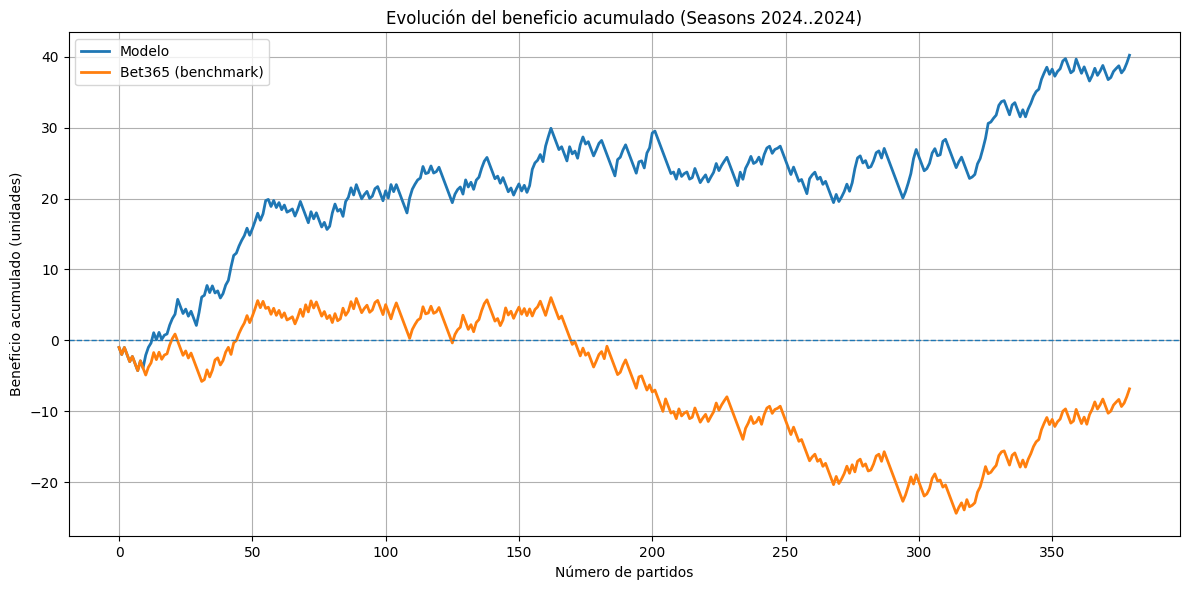

In [ ]:
tabla = plot_cumulative_profit_model_vs_bet365(df, model, scaler, train_until_season=2023, test_until_season=2024, with_odds=True, meta_df=df_old, stake=1.0)

# **Modelos por fase de la temporada**

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/TFM/data/processed/df_final.parquet'

df = pd.read_parquet(file_path)

df.head()

,Date,FTR,B365H,B365D,B365A,h_elo,a_elo,Season,h_avg_age,h_value_mio,...,pimp1,pimpx,pimp2,fase_temporada,has_xg_data,target,home_playstyle_equilibrado,home_playstyle_ofensivo,away_playstyle_equilibrado,away_playstyle_ofensivo
380,2006-08-26,H,1.57,3.60,6.00,1857.375122,1726.076904,2006,26.5,232.70,...,0.589005,0.256872,0.154123,inicio,0,2,1,0,1,0
381,2006-08-27,D,2.30,3.25,3.00,1701.504761,1723.469849,2006,27.1,41.90,...,0.404145,0.286010,0.309845,inicio,0,1,1,0,1,0
382,2006-08-27,D,1.53,3.80,6.00,1883.077393,1829.429443,2006,25.3,372.20,...,0.603270,0.242896,0.153834,inicio,0,1,1,0,1,0
383,2006-08-27,A,3.10,3.20,2.25,1693.620361,1769.739990,2006,25.9,49.30,...,0.298817,0.289479,0.411704,inicio,0,0,1,0,1,0
384,2006-08-27,A,1.83,3.30,4.33,1756.190308,1762.177246,2006,25.2,71.35,...,0.505771,0.280473,0.213756,inicio,0,0,1,0,1,0


## Modelo INICIO

In [ ]:
df_inicio = df[df['fase_temporada'] == 'inicio']

In [ ]:
drop_cols = ['fase_temporada', 'FTR', 'target', 'Date','has_xg_data', 'overround', 'pimp1', 'a_pct_foreigners']

In [ ]:
X_inicio = df_inicio.drop(columns=drop_cols)
y_inicio = df_inicio['target']

In [ ]:
X_train_inicio = X_inicio[df_inicio['Season'] <= 2023]
y_train_inicio = y_inicio[df_inicio['Season'] <= 2023]

X_test_inicio = X_inicio[df_inicio['Season'] > 2023]
y_test_inicio = y_inicio[df_inicio['Season'] > 2023]

In [ ]:
X_train_inicio = X_train_inicio.drop(columns=['Season'])
X_test_inicio = X_test_inicio.drop(columns=['Season'])

y_train_inicio = y_train_inicio.drop(columns=['Season'])
y_test_inicio = y_test_inicio.drop(columns=['Season'])

In [ ]:
len(X_train_inicio)

2378

In [ ]:
len(X_test_inicio)

137

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss

# Pipeline con escalado + regresión logística
model_inicio = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

# Entrenar
model_inicio.fit(X_train_inicio, y_train_inicio)

# Predicciones
y_train_pred_inicio = model_inicio.predict(X_train_inicio)
y_train_proba_inicio = model_inicio.predict_proba(X_train_inicio)
y_test_pred_inicio = model_inicio.predict(X_test_inicio)
y_test_proba_inicio = model_inicio.predict_proba(X_test_inicio)

# Evaluación
print("Logistic Regression multinomial (INICIO):")

print("\n=== Train ===")
print("Accuracy:", accuracy_score(y_train_inicio, y_train_pred_inicio))
print("Log Loss:", log_loss(y_train_inicio, y_train_proba_inicio))

print("\n=== Test ===")
print("Accuracy:", accuracy_score(y_test_inicio, y_test_pred_inicio))
print("Log Loss:", log_loss(y_test_inicio, y_test_proba_inicio))

Logistic Regression multinomial (INICIO):

=== Train ===
Accuracy: 0.5592935239697224
Log Loss: 0.9367516269785796

=== Test ===
Accuracy: 0.5328467153284672
Log Loss: 0.9592955079897749


In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np

# Variables de entrada y objetivo
X_bet = df_inicio[['B365H', 'B365D', 'B365A']]
y_bet = df_inicio['FTR'].map({'A': 0, 'D': 1, 'H': 2})
y_bet_bin = label_binarize(y_bet, classes=[0, 1, 2])

# Calcular probabilidades implícitas sin margen
prob_h = 1 / X_bet['B365H']
prob_d = 1 / X_bet['B365D']
prob_a = 1 / X_bet['B365A']

overround = prob_h + prob_d + prob_a
prob_h /= overround
prob_d /= overround
prob_a /= overround

# Predicción basada en la mayor probabilidad
bet365_pred = np.array([
    np.argmax([a, d, h])  # 0 = Away, 1 = Draw, 2 = Home
    for a, d, h in zip(prob_a, prob_d, prob_h)
])

# Matriz de probabilidades para log loss
bet365_proba = np.column_stack([prob_a, prob_d, prob_h])

# Evaluación
acc_inicio = accuracy_score(y_bet, bet365_pred)
logloss_inicio = log_loss(y_bet_bin, bet365_proba)

print("Accuracy cuotas (fase inicio):", acc_inicio)
print("Log Loss cuotas (fase inicio):", logloss_inicio)

Accuracy cuotas (fase inicio): 0.5339960238568588
Log Loss cuotas (fase inicio): 0.9689888955708615


## Modelo MITAD

In [ ]:
df_mitad = df[df['fase_temporada'] == 'mitad']

drop_cols = ['fase_temporada', 'FTR', 'target', 'Date','has_xg_data', 'overround', 'pimp1', 'a_pct_foreigners']

X_mitad = df_mitad.drop(columns=drop_cols)
y_mitad = df_mitad['target']

X_train_mitad = X_mitad[df_mitad['Season'] <= 2023]
y_train_mitad = y_mitad[df_mitad['Season'] <= 2023]

X_test_mitad = X_mitad[df_mitad['Season'] > 2023]
y_test_mitad = y_mitad[df_mitad['Season'] > 2023]

X_train_mitad = X_train_mitad.drop(columns=['Season'])
X_test_mitad = X_test_mitad.drop(columns=['Season'])

y_train_mitad = y_train_mitad.drop(columns=['Season'])
y_test_mitad = y_test_mitad.drop(columns=['Season'])

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss

# Pipeline con escalado + regresión logística
model_mitad = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

# Entrenar
model_mitad.fit(X_train_mitad, y_train_mitad)

# Predicciones
y_train_pred_mitad = model_mitad.predict(X_train_mitad)
y_train_proba_mitad = model_mitad.predict_proba(X_train_mitad)
y_test_pred_mitad = model_mitad.predict(X_test_mitad)
y_test_proba_mitad = model_mitad.predict_proba(X_test_mitad)

# Evaluación
print("Logistic Regression multinomial (MITAD):")

print("\n=== Train ===")
print("Accuracy:", accuracy_score(y_train_mitad, y_train_pred_mitad))
print("Log Loss:", log_loss(y_train_mitad, y_train_proba_mitad))

print("\n=== Test ===")
print("Accuracy:", accuracy_score(y_test_mitad, y_test_pred_mitad))
print("Log Loss:", log_loss(y_test_mitad, y_test_proba_mitad))

Logistic Regression multinomial (MITAD):

=== Train ===
Accuracy: 0.5556989247311828
Log Loss: 0.93106415341006

=== Test ===
Accuracy: 0.5
Log Loss: 1.0832087367408858


In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np

# Variables de entrada y objetivo
X_bet = df_mitad[['B365H', 'B365D', 'B365A']]
y_bet = df_mitad['FTR'].map({'A': 0, 'D': 1, 'H': 2})
y_bet_bin = label_binarize(y_bet, classes=[0, 1, 2])

# Calcular probabilidades implícitas sin margen
prob_h = 1 / X_bet['B365H']
prob_d = 1 / X_bet['B365D']
prob_a = 1 / X_bet['B365A']

overround = prob_h + prob_d + prob_a
prob_h /= overround
prob_d /= overround
prob_a /= overround

# Predicción basada en la mayor probabilidad
bet365_pred = np.array([
    np.argmax([a, d, h])  # 0 = Away, 1 = Draw, 2 = Home
    for a, d, h in zip(prob_a, prob_d, prob_h)
])

# Matriz de probabilidades para log loss
bet365_proba = np.column_stack([prob_a, prob_d, prob_h])

# Evaluación
acc_mitad = accuracy_score(y_bet, bet365_pred)
logloss_mitad = log_loss(y_bet_bin, bet365_proba)

print("Accuracy cuotas (fase mitad):", acc_mitad)
print("Log Loss cuotas (fase mitad):", logloss_mitad)

Accuracy cuotas (fase mitad): 0.5369237046103631
Log Loss cuotas (fase mitad): 0.9664413990317429


## Modelo FINAL

In [ ]:
df_final = df[df['fase_temporada'] == 'final']

drop_cols = ['fase_temporada', 'FTR', 'target', 'Date','has_xg_data', 'overround', 'pimp1', 'a_pct_foreigners']

X_final = df_final.drop(columns=drop_cols)
y_final = df_final['target']

X_train_final = X_final[df_final['Season'] <= 2023]
y_train_final = y_final[df_final['Season'] <= 2023]

X_test_final = X_final[df_final['Season'] > 2023]
y_test_final = y_final[df_final['Season'] > 2023]

X_train_final = X_train_final.drop(columns=['Season'])
X_test_final = X_test_final.drop(columns=['Season'])

y_train_final = y_train_final.drop(columns=['Season'])
y_test_final = y_test_final.drop(columns=['Season'])

len(X_train_final)

len(X_test_final)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss

# Pipeline con escalado + regresión logística
model_final = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

# Entrenar
model_final.fit(X_train_final, y_train_final)

# Predicciones
y_train_pred_final = model_final.predict(X_train_final)
y_train_proba_final = model_final.predict_proba(X_train_final)
y_test_pred_final = model_final.predict(X_test_final)
y_test_proba_final = model_final.predict_proba(X_test_final)

# Evaluación
print("Logistic Regression multinomial:")

print("\n=== Train ===")
print("Accuracy:", accuracy_score(y_train_final, y_train_pred_final))
print("Log Loss:", log_loss(y_train_final, y_train_proba_final))

print("\n=== Test ===")
print("Accuracy:", accuracy_score(y_test_final, y_test_pred_final))
print("Log Loss:", log_loss(y_test_final, y_test_proba_final))

Logistic Regression multinomial:

=== Train ===
Accuracy: 0.5694899391670566
Log Loss: 0.9104440710091384

=== Test ===
Accuracy: 0.5042735042735043
Log Loss: 0.9755798208990906


In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np

# Variables de entrada y objetivo
X_bet = df_final[['B365H', 'B365D', 'B365A']]
y_bet = df_final['FTR'].map({'A': 0, 'D': 1, 'H': 2})
y_bet_bin = label_binarize(y_bet, classes=[0, 1, 2])

# Calcular probabilidades implícitas sin margen
prob_h = 1 / X_bet['B365H']
prob_d = 1 / X_bet['B365D']
prob_a = 1 / X_bet['B365A']

overround = prob_h + prob_d + prob_a
prob_h /= overround
prob_d /= overround
prob_a /= overround

# Predicción basada en la mayor probabilidad
bet365_pred = np.array([
    np.argmax([a, d, h])  # 0 = Away, 1 = Draw, 2 = Home
    for a, d, h in zip(prob_a, prob_d, prob_h)
])

# Matriz de probabilidades para log loss
bet365_proba = np.column_stack([prob_a, prob_d, prob_h])

# Evaluación
acc_final = accuracy_score(y_bet, bet365_pred)
logloss_final = log_loss(y_bet_bin, bet365_proba)

print("Accuracy cuotas (fase final):", acc_final)
print("Log Loss cuotas (fase final):", logloss_final)

Accuracy cuotas (fase final): 0.5607808340727596
Log Loss cuotas (fase final): 0.9427790451312839


In [ ]:
!jupyter nbconvert --to html /content/MODELOS.ipynb

[NbConvertApp] Converting notebook /content/MODELOS.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 1267860 bytes to /content/MODELOS.html
